# SÍNTESIS DE VOZ CON CUATRO SINUSOIDES

Grupo: Eric Castellano, Gerard Comas, Héctor Sama y Marcel Tomás

# Parte A. Análisis

La señal de voz decae muy rápidamente en frecuencias altas y la estimación de las altas componentes
frecuenciales se puede degradar. Para paliar este efecto se aplica un preprocesado a la señal de voz consistente
en un filtro de preénfasis que enfatiza la señal en altas frecuencias y, a continuación, se hace un análisis frecuencial por tramas. Se pide:

1. Filtre la señal a analizar con el filtro de pre-enfásisis $H(F) = 1−0.9e^{−j2πF}$ . Para ello puede usar la función lfilter del paquete scipy.signal (ver anexo).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hamming, lfilter, spectrogram
from scipy.io import wavfile
from IPython.display import Audio
from lpc import lpc #lpc en Atenea, de https://github.com/cournape/talkbox con modificaciones

%matplotlib widget

In [2]:
#Lectura del fichero
samplerate, x = wavfile.read('f1.wav')
x = x / 2**15 #IMPORTANTE: normaliza y convierte a float los datos

#Pre-emphasis
pre = np.array([1, -0.9])
s = lfilter(pre, 1, x)

2. Segmente la señal filtrada en tramas de 30 ms (frame length L = 240 muestras) solapadas 15 ms (framedelay D = 120 muestras).


In [3]:
s2 = []
i = 0
while 120*i + 240 < len(x):
    s2.append(x[120*i:120*i+240]) 
    i += 1
    
ntram = i - 1

3. Para cada trama, enventanada con una ventana de Hamming, realice un análisis LPC, es decir, obtenga los coeficientes ai y la ganancia b que simulan el tracto vocal mediante la ecuación (1) en la que L es la longitud de la trama de análisis x. Para ello utilice la función lpc proporcionada, (ai, G) = lpc (x, P). La ganancia G es el cuadrado del coeficiente b de la ecuación (1).

In [4]:
sv = []
av = []
bv = []
i = 0
p = 8
while 120*i + 240 < len(x):
    sv.append(s2[i]*hamming(len(s2[i])))
    #Coeficientes lpc para una trama
    a, e, k = lpc(sv[i], p)
    b = np.sqrt(e) #la función lfilter da problemas si b es un escalar
    av.append(a)
    bv.append(b)
    i += 1

## Parte B. Cálculo de formantes

La función de transferencia de un filtro autorregresivo como el planteado en ecuación (1) es: $H(z)=\frac{b}{1+\sum\limits_{i=1}^{P}a_iz^{-i}}=\frac{...}{(1-p_1z^{-1})(1-p_2z^{-1})...(1-p_pz^{-1})}  (3)$

Las raíces, $p_i$ con $i = 1,...,P$, del polinomio del denominador $A(z)=1+\sum\limits_{i-1}^{P}a_iz^{-i}$ se denominan polos. Dado que los coeficientes de $A(z)$ son reales, sus raíces serán reales o aparecerán en pares complejos conjugados.
Sustituyendo $z = e^{j2πF}$ en $H(z)$ se obtiene la respuesta frecuencial: $H(F) = H(z)|_{z=ej2πF}$.
En el ejemplo de la figura 1 aparece un diagrama de ceros (valores de $z$ para los que $H(z) = 0$, marcados con ’o’) y polos (valores de $z$ para los que $H(z) = ∞$, marcados con ’x’) y el módulo de la respuesta frecuencial correspondiente. Si un punto del círculo de radio unidad, $z = e^{j2πF0}$, está próximo a un polo $p_i$, el valor de $|1 − p_iz^{−1}|$ es pequeño y, por tanto, $|H(F_0)|$ es grande.

Vemos que la posición de los picos $|H(F)|$ en frecuencia está relacionada con las fases de los polos. Por otra parte, cuanto más cerca del círculo unidad esté el módulo del polo, mayor será la amplitud del pico.

4. Para cada trama, halle las amplitudes y frecuencias de 4 formantes. Como estamos usando un filtro de orden P = 8, tendremos 4 pares de polos pi complejos conjugados o menos si alguna raíz es real. Siga el siguiente procedimiento (aunque en la literatura puede encontrar otros métodos de selección también válidos):


In [5]:
FF = []
A = []
i = 0

#Estimación de formates
while 120*i + 240 < len(x):
    rts = np.roots(av[i])
    rts = rts[np.imag(rts)>0] #solo fases positivas
    idx = np.argsort(np.angle(rts))
    rts = rts[idx]
    Frqs = np.angle(rts)/(2*np.pi) #frecuencia normalizada de cada formante  
    Mags = bv[i]/(1-abs(rts))
    FF.append(Frqs)
    A.append(Mags)
    i += 1

# Parte C. Generación de la señal sintética


En el apartado anterior hemos obtenido las amplitudes y frecuencias de cada formantes en cada trama k, pero las tramas se van a sintetizar cada D muestras. Por tanto, hay que interpolar los valores de la trama k con los de la trama k + 1 y esto se realiza mediante una interpolación lineal. Debemos asegurarnos que las frecuencias y amplitudes de los formantes para cada trama están ordenadas de menor a mayor según el orden de frecuencias para no cometer el error de interpolar el primer formante de una trama con otro formante de otra trama.


$F_f^{(k)}[n]=\frac{D-n}{D}F_f^{(k)}[n]+\frac{n}{D}F_f^{(k+1)}[n],   0\leq n \leq D-1$

$A_f^{(k)}[n]=\frac{D-n}{D}A_f^{(k)}[n]+\frac{n}{D}A_f^{(k+1)}[n],   {0}\leq{n}\leq{D-1}$

$F_f=concatenar(F_f^{(1)},F_f^{(2)},F_f^{(k)}, ...);         A_f=concatenar(A_f^{(1)},A_f^{(2)},A_f^{(k)}, ...)$

Nota: es posible que en algunas tramas solo se detecten dos o tres formantes. En ese caso las amplitudes de la trama $k$ para el formante $f$ no detectado debería ponerse a cero sin interpolar.

A continuación, las fases se obtienen acumulando los valores de las frecuencias ($N_T$ es la longitud total de la señal a sintetizar):

$ϕ_f[n]=\sum\limits_{m=0}^{n}2πF_f[m],  {0}\leq{n}\leq{N_T}$

5. Sintetice la señal sintética de acuerdo con la ecuación (2) y escuche el resultado.

In [6]:
FrecuenciaFundamentalInterpolada1N = []
FrecuenciaFundamentalInterpolada2N = []
FrecuenciaFundamentalInterpolada3N = []
FrecuenciaFundamentalInterpolada4N = []

AmplitudInterpolada1N = []
AmplitudInterpolada2N = []
AmplitudInterpolada3N = []
AmplitudInterpolada4N = []

D = 120 
i = 0

while 120*i + 240 < len(x) - 120: #no podemos interpolar la última trama 
    FrecuenciaFundamentalInterpolada1 = []
    FrecuenciaFundamentalInterpolada2 = []
    FrecuenciaFundamentalInterpolada3 = []
    FrecuenciaFundamentalInterpolada4 = []
    
    AmplitudInterpolada1 = []
    AmplitudInterpolada2 = []
    AmplitudInterpolada3 = []
    AmplitudInterpolada4 = []
    for n in range(D):
        FFN = np.zeros(4)
        AN = np.zeros(4)
        for j in range (4):
            try: 
                FFN[j] = (D-n)/D*FF[i][j] + n/D*FF[i+1][j]
                AN[j] = (D-n)/D*A[i][j] + n/D*A[i+1][j]   
            except:
                if len(FF[i]) > j:
                    FFN[j] = (D-n)/D*FF[i][j]
                elif len(FF[i+1]) > j:
                    FFN[j] =  n/D*FF[i+1][j]
                    
        FrecuenciaFundamentalInterpolada1.append(FFN[0])
        FrecuenciaFundamentalInterpolada2.append(FFN[1])
        FrecuenciaFundamentalInterpolada3.append(FFN[2])
        FrecuenciaFundamentalInterpolada4.append(FFN[3])
        AmplitudInterpolada1.append(AN[0])
        AmplitudInterpolada2.append(AN[1]) 
        AmplitudInterpolada3.append(AN[2]) 
        AmplitudInterpolada4.append(AN[3]) 
    i += 1
    FrecuenciaFundamentalInterpolada1N.append(FrecuenciaFundamentalInterpolada1)
    FrecuenciaFundamentalInterpolada2N.append(FrecuenciaFundamentalInterpolada2) 
    FrecuenciaFundamentalInterpolada3N.append(FrecuenciaFundamentalInterpolada3)
    FrecuenciaFundamentalInterpolada4N.append(FrecuenciaFundamentalInterpolada4)
    AmplitudInterpolada1N.append(AmplitudInterpolada1)
    AmplitudInterpolada2N.append(AmplitudInterpolada2)
    AmplitudInterpolada3N.append(AmplitudInterpolada3)
    AmplitudInterpolada4N.append(AmplitudInterpolada4)
    


In [7]:
speech = []

for trama in range(ntram):
    fases1 = 2*np.pi*np.cumsum(FrecuenciaFundamentalInterpolada1N[trama])
    fases2 = 2*np.pi*np.cumsum(FrecuenciaFundamentalInterpolada2N[trama])
    fases3 = 2*np.pi*np.cumsum(FrecuenciaFundamentalInterpolada3N[trama])
    fases4 = 2*np.pi*np.cumsum(FrecuenciaFundamentalInterpolada4N[trama])
    
    formantspeech = AmplitudInterpolada1N[trama]*np.cos(fases1) + AmplitudInterpolada2N[trama]*np.cos(fases2) + AmplitudInterpolada3N[trama]*np.cos(fases3) + AmplitudInterpolada4N[trama]*np.cos(fases4)
    speech.append(formantspeech)
    
speech = np.concatenate(speech)

In [8]:
#Escuchar voz sintetizada
speech = speech.astype(np.float32) #IMPORTANTE: SI NO, NO SE OYE

wavfile.write('speech.wav', 8000, speech)
Audio('speech.wav', autoplay=False)


# Parte D. Respresentación de las señales

6. Represente el espectograma de la señal original, de la señal sintetizada con las sinusoides y de una señal sintética mediante un vocoder lpc de orden 10 excitado únicamente con ruido gaussiano, tal y como la generaba en el trabajo del vocoder.

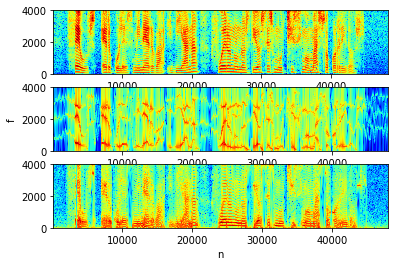

In [16]:
L, R, N2 = 240, 120, 1024
fm = 8000

plt.subplot(3,1,1)
# espectograma de la original con preenfasis
f1, t1, spectrogram1 = spectrogram(s, window = hamming(L), nperseg=L, noverlap=R, nfft=N2)
plt.pcolormesh(t1, f1*fm, 10*np.log10(np.abs(spectrogram1)+1e-10), cmap='jet')
plt.plot()
s = s.astype(np.float32) 

plt.subplot(3,1,2)
# espectograma de la señal sintetizada con las sinusoides
f2, t2, spectrogram2 = spectrogram(speech, window = hamming(L), nperseg=L, noverlap=R, nfft=N2)
plt.pcolormesh(t2, f2*fm, 10*np.log10(np.abs(spectrogram2)+1e-10), cmap='jet')
plt.ylabel('f', fontsize=10)
plt.plot()

plt.subplot(3,1,3)
# espectograma de la señal sintetizada de una señal sintética mediante un vocoder lpc 
bv2 = []
av2 = []
p = 10
for i in range (ntram):
    a, e, k = lpc(s2[i], p)
    b = np.array([np.sqrt(e)]) 
    bv2.append(b)
    av2.append(a)
    

N = np.zeros(ntram)
sonora = np.zeros(ntram) # 0 sorda i 1 sonora

for i in range(401):
    ti = s[120*i:120*i+240]
    ri = np.correlate(ti, ti, 'full')
    
    rmin = np.argmin(ri[239:]) + 239
    rmax = np.argmax(ri[rmin:]) + rmin
    
    Ni = rmax - 239
    N[i] = Ni
    
    if ri[239+Ni]/ri[239] >= 0.5:
        sonora[i] = 1
    else:
        N[i] = 0

ss = []
zf = np.zeros(10)
x = np.zeros((ntram, 120))
for j in range (ntram):
    if not sonora[j]:
        x[j] = np.random.normal(0, 1, 120)
    else:
        while(i < n):
            if i >= 0:
                x[j, i] = np.sqrt(N[j])
            i += int(N[j])
        i = int(N[j+1]) - (120 - i + int(N[j]))
        
for i in range (ntram):
    h1, zf = lfilter(bv2[i], av2[i], x[i], axis=- 1, zi=zf)
    ss.extend(h1)
    
ss = np.array(ss)
ss = ss.astype(np.float32)

f3, t3, spectrogram3 = spectrogram(ss, window = hamming(L), nperseg=L, noverlap=R, nfft=N2)
plt.pcolormesh(t3, f3*fm, 10*np.log10(np.abs(spectrogram3)+1e-10), cmap='jet')
plt.xlabel('n', fontsize=10)
plt.show()

7. Comente las particularidades que encuentre tanto al escuchar las señales como al comparar los espectrogramas.

En el espectograma podemos ver que la segunda gráfica, la de los sinuoides, no se aproxima tanto a la original como la tercera. Pero como ya se nos explico al iniciar la práctica, para modular la voz humana se suelen usar unos 40 harmónicos.
Pasa lo mismo con los audios. Aun así, resulta sorprendente que con tan solo 4 sinusoides podamos representar la voz humana. 

In [13]:
wavfile.write('s.wav', 8000, s)
Audio('s.wav', autoplay=False)

In [14]:
wavfile.write('speech.wav', 8000, speech)
Audio('speech.wav', autoplay=False)

In [17]:
wavfile.write('ss.wav', 8000, ss)
Audio('ss.wav', autoplay=False)